# Modern CLI Design in Python

This session is aims to give a basic overview of what a CLI is, when it should be use, what are the concerns around using CLIs, and what are the packages available in Python for creating CLI applications.


## What is a CLI?


What is a Command Line Interface (CLI)? A CLI is a command line program that accepts text input to execute particular functions. CLIs date back to the early days of computing and acted as a bridge between punch cards and the modern day Graphical User Interface (GUI) in terms of communicating with programs written by developers. CLIs are relatively primative in this sense, but still incredibly useful in a modern setting if used correctly.

## When Should You Use a CLI

* When you need fine-grained control over your actions or require advanced functionality not available in a GUI.
* When you are building programs that are meant to be run by a more sophisticated user base where customization of parameters is necessary and is not easily achieved through configuration files.
* When you are working in a low-resource environment or through a remote connection.

## CLI Security Concerns

There are some general security concerns when working with CLIs:

* **Injection attacks**: When parsing user input from the command line, it is essential to properly sanitize and validate input data to prevent malicious code from being executed.
 <br>
 <br>
* **Sensitive data exposure**: Avoid passing sensitive information, such as passwords, directly through command-line arguments, as it might be visible to other users or logged in system logs. Instead, use secure input methods, such as environment variables or interactive prompts.
 <br>
 <br>
* **Updates and dependency management**: Since most CLI tools in Python come from 3rd party packages, there is always a concern with security vulnerabilities introduced by those packages. You can scan your dependencies for known vulnerabilities using tools like PyUp or Dependabot.
 <br>
 <br>

By addressing these concerns, you can minimize security risks when developing CLI applications with any of the mentioned packages.

### Examples of Security Concerns - Unchecked User Input

```python
# injection_attack.py
import sys
import sqlite3

def run_query(conn, create_table_sql):
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Exception as e:
        print(e)

create_table = """
CREATE TABLE IF NOT EXISTS users (
    id integer PRIMARY KEY AUTOINCREMENT,
    name text NOT NULL
);"""

insert_records = """
INSERT INTO users (name) VALUES ('Alice');
INSERT INTO users (name) VALUES ('Bob');
INSERT INTO users (name) VALUES ('Charlie');
"""

conn = sqlite3.connect("database.db")
run_query(conn, create_table)
conn.executescript(insert_records)
conn.commit()

def main():
    user_id = sys.argv[1]
    query = f"SELECT name FROM users WHERE id = {user_id}"

    conn = sqlite3.connect("database.db")
    cursor = conn.cursor()
    cursor.execute(query)
    result = cursor.fetchall()

    if result:
        print(f"User name: {result}")
    else:
        print("User not found")

if __name__ == "__main__":
    main()
```

In [ ]:
!python injection_attack.py 1

In [ ]:
!python injection_attack.py "1 OR 1=1"

### Solution

Anytime you are accepting input of any kind, you should be absolutely sure it is of the type and shape you are expecting. If you are taking in an ID, make sure it is a number and only a number. Remove special characters that you are not expecting. Never think, "this is only being used by people I work with, they aren't going to misuse it." Remember, you can never be sure your programs will only be used by trusted actors and you should always keep in mind that misuse is not always malicious or intentional.

### Examples of Security Concerns - Secret Leaks

```python
# secret_leak.py
import sys
import time

def login(user_name, password):
    print("You're in")


def main():
    user_name = sys.argv[1]
    password = sys.argv[2]
    time.sleep(10)
    login(user_name, password)

if __name__ == "__main__":
    main()
```

In [ ]:
import os
get_ipython().system = os.system

!nohup python secret_leak.py me password123 &

In [ ]:
!ps aux | grep secret_leak.py

### Solution

There are several way to make passing sensitive data more secure. On one hand, you can use environment variables instead of command line arguments. You may be thinking "isn't that also insecure because someone could just run `printenv` and see that sensitive data" and you would be correct. However, environment variables are only visible to the user with those variables set, not all users on a computer or server. With command line arguments, any user in the system can see what is passed.

Ideally, all secrets should be stored in an encrypted password manager such as GCP or AWS Secret Manager.

## Now for the Good Stuff

Today, we are going to be exploring 4 CLI tools: Argparse, Click, Fire, and Typer. Generally, you can think of these tools in 2 categories. Argparse and Click are tired and true. They have both been around for a decade or more at this point and are well used, if not a bit antiquated. Fire and Typer are the new kids on the block and represent a resent revival in interest in building better CLIs in Python.

To center our discussion, we will be exploring a database of UFO sightings over the past 20 years or so ([source](https://github.com/planetsig/ufo-reports)).

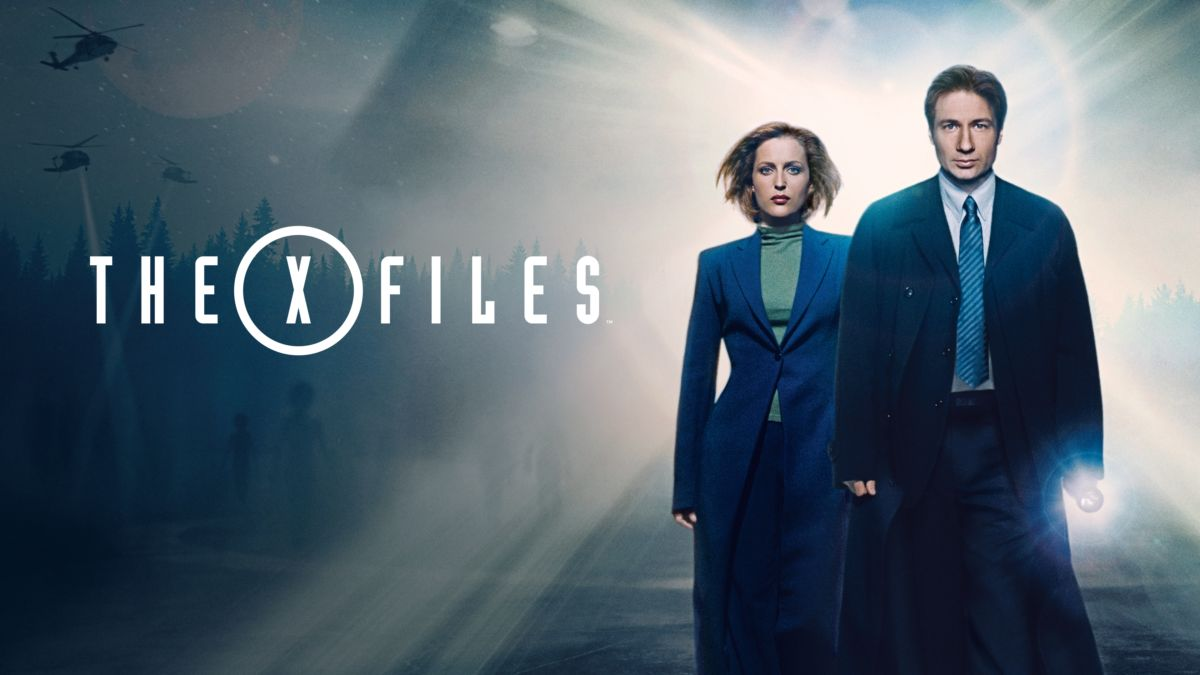

##

In [ ]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/planetsig/ufo-reports/master/csv-data/ufo-scrubbed-geocoded-time-standardized.csv")

In [ ]:
df.head()

In [ ]:
df.columns = ["incident_time", "city", "state", "country", "type", "drop", "duration", "description", "date", "lat", "long"]


In [ ]:
del df["drop"]

In [ ]:
df.head()

In [ ]:
#df.to_csv("close_encounters.csv", index=False)

In [ ]:
# df.sample(5_000).reset_index().to_csv("close_encounters.csv", index=False)

## Argparse

The step up from sys.argv. Argparse is all around better than argv. It makes it easy to auto generate help messages, it has built in error handling for common errors, it makes code a bit more readable, it provides a method for passing default values, which aids in testing, finally, argparse ships with Python as a default package and has since Python 2.7, so it has been widely used and understood for awhile.

```python
# the_truth_is_out_there.py
import argparse
import pandas as pd


def load_data():
    return pd.read_csv("close_encounters.csv")


def city_with_most_encounters(args):
    state = args.state.lower()
    df = load_data()
    df["state"] = df["state"].str.lower()
    filtered_df = df[df["state"] == state]
    city_counts = filtered_df["city"].str.lower().value_counts()
    top_city = city_counts.idxmax()
    print(f"The city with the most UFO encounters in {state.upper()} is: {top_city.capitalize()}")

    
parser = argparse.ArgumentParser()
parser.add_argument("state", help="State abbreviation to find the city with the most UFO encounters")
parser.set_defaults(func=city_with_most_encounters)

args = parser.parse_args()
args.func(args)
```

In [ ]:
!python the_truth_is_out_there.py --help

In [ ]:
!python the_truth_is_out_there.py va

## Click

Click came around about 4 years after argparse and greatly simplified the syntax of using command line arguments. Click was created by Armin Ronacher, the author of the Flask web framework, (we will see this is a bit of a theme). As mentioned, click has a much simpler syntax and is easier to read, additionally, click makes heavy use of docorators allowing it to pack a lot of functionality into a small amount of code

```python
# their_eyes_were_watching_god.py
import click
import pandas as pd


def load_data():
    return pd.read_csv("close_encounters.csv")


@click.group()
def cli():
    pass


@click.group()
def count():
    pass


cli.add_command(count)


@count.command()
@click.argument("shape")
def shape(shape):
    df = load_data()
    count_shape = df[df["type"] == shape].shape[0]
    click.echo(f"Number of {shape} sightings: {count_shape}")

    
@count.command()
@click.argument("date")
def before(date):
    df = load_data()
    df["incident_time"] = pd.to_datetime(df["incident_time"])
    date = pd.to_datetime(date)
    count_before = df[df["incident_time"] < date].shape[0]
    click.echo(f"Number of encounters before {date.strftime('%m/%d/%Y')}: {count_before}")

    
@count.command()
@click.argument("date")
def after(date):
    df = load_data()
    df["incident_time"] = pd.to_datetime(df["incident_time"])
    date = pd.to_datetime(date)
    count_after = df[df["incident_time"] > date].shape[0]
    click.echo(f"Number of encounters after {date.strftime('%m/%d/%Y')}: {count_after}")

    
@click.group()
def details():
    pass


cli.add_command(details)


@details.command()
@click.argument("column_name")
def column(column_name):
    df = load_data()
    distinct_values = df[column_name].unique()
    click.echo(f"Distinct values for {column_name}:")
    for value in distinct_values:
        click.echo(value)
   
        
if __name__ == "__main__":
    cli()
```

In [ ]:
!python their_eyes_were_watching_god.py details --help

In [ ]:
!python their_eyes_were_watching_god.py details column type

In [ ]:
!python their_eyes_were_watching_god.py count shape egg

In [ ]:
!python their_eyes_were_watching_god.py count before "07/23/2000"

## Fire

Excuse the pun, but Fire is the "fire and forget it" of CLI tools. Developed by Google in 2017 (3 years after click), fire provides a simple way to create CLIs in Python, by automatically generating a CLI from any Python module, class, or function.

```python
# mars_attacks.py
import fire
import pandas as pd
import pprint

def load_data():
    return pd.read_csv("close_encounters.csv")


class App:
    def shuffle_descriptions(self, sample_num):
        df = load_data()
        print("Enjoy some random descriptions:")
        for d in df["description"].sample(sample_num):
            pprint.pprint(d)
            print("\n")

if __name__ == "__main__":
    fire.Fire(App)
```

In [ ]:
!python mars_attacks.py shuffle_descriptions 20

In [ ]:
!python mars_attacks.py shuffle_descriptions 1

## Typer

Full disclosure, typer is my personal favorite. Typer was built by Sebastián Ramírez, who you may know better as [tiangolo](https://github.com/tiangolo) the creator of FastAPI. Typer was released in 2020. Like tiangolo's other projects, typer makes heavy use of type hinting. Stylistically, it is very similar to click, for good reason, it is built off of click. As such, the syntax is easy to read and revolves around decorators.

```python
# the_nth_element.py

import typer
import pandas as pd
from rich import print
from rich.table import Table


app = typer.Typer()


def load_data():
    return pd.read_csv("close_encounters.csv")


def combine_city_state(row):
    city = row['city']
    state = row['state']
    
    if city and state:
        return f"{city}, {state}"
    elif city:
        return city
    elif state:
        return state
    else:
        return None

    
def get_top_cities(df, shape: str, top_n: int):
    filtered_df = df[df['type'] == shape].copy()
    filtered_df['city_state'] = filtered_df.apply(combine_city_state, axis=1)
    filtered_df['city_state'] = filtered_df.apply(combine_city_state, axis=1)
    city_counts = filtered_df["city_state"].value_counts()
    return city_counts.nlargest(top_n)


@app.command()
def top_sightings(shape: str = "circle", top_n: int = 10, debug: bool = False):
    if debug:
        typer.echo("Debug mode is on")

    df = load_data()
    
    if debug:
        typer.echo(f"Filtering by shape: {shape}")

    top_cities = get_top_cities(df, shape, top_n)

    if debug:
        typer.echo("Displaying results:")
    
    for index, (city, count) in enumerate(top_cities.items(), start=1):
        typer.echo(f"{index}. {city}, state: {count} sightings")
        
        
        
@app.command()
def top_sightings_with_style(shape: str = "circle", top_n: int = 10, debug: bool = False):
    if debug:
        typer.echo("Debug mode is on")

    df = load_data()

    if debug:
        typer.echo(f"Filtering by shape: {shape}")

    top_cities = get_top_cities(df, shape, top_n)

    if debug:
        typer.echo("Displaying results:")

    table = Table(title=f"Top {top_n} Cities with {shape.capitalize()} UFO Sightings")
    table.add_column("Rank", justify="right")
    table.add_column("City")
    table.add_column("Sightings", justify="right")

    for index, (city, count) in enumerate(top_cities.items(), start=1):
        table.add_row(str(index), city, str(count))
        
    print(table)

    

if __name__ == "__main__":
    app()
```

In [2]:
!python the_nth_element.py top-sightings --help

                                                                                
 Usage: the_nth_element.py top-sightings [OPTIONS]                              
                                                                                
╭─ Options ────────────────────────────────────────────────────────────────────╮
│ --shape                  TEXT     [default: circle]                          │
│ --top-n                  INTEGER  [default: 10]                              │
│ --debug    --no-debug             [default: no-debug]                        │
│ --help                            Show this message and exit.                │
╰──────────────────────────────────────────────────────────────────────────────╯



In [3]:
!python the_nth_element.py top-sightings --shape "egg"

/Users/chasehudson/code/code-dojo/modules/07_modern_python_cli/the_nth_element.py:9: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv("close_encounters.csv")
1. seattle, wa, state: 6 sightings
2. los angeles, ca, state: 5 sightings
3. london (uk/england), nan, state: 4 sightings
4. phoenix, az, state: 4 sightings
5. toronto (canada), on, state: 4 sightings
6. hayward, ca, state: 4 sightings
7. san diego, ca, state: 4 sightings
8. worcester, ma, state: 4 sightings
9. cleveland, oh, state: 3 sightings
10. vancouver, wa, state: 3 sightings


In [7]:
!python the_nth_element.py top-sightings --shape "cigar" --top-n 50

/Users/chasehudson/code/code-dojo/modules/07_modern_python_cli/the_nth_element.py:9: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv("close_encounters.csv")
1. los angeles, ca, state: 16 sightings
2. phoenix, az, state: 14 sightings
3. sacramento, ca, state: 13 sightings
4. seattle, wa, state: 11 sightings
5. chicago, il, state: 9 sightings
6. san diego, ca, state: 8 sightings
7. las vegas, nv, state: 7 sightings
8. memphis, tn, state: 7 sightings
9. st. louis, mo, state: 7 sightings
10. charlotte, nc, state: 6 sightings
11. new york city (brooklyn), ny, state: 6 sightings
12. london (uk/england), nan, state: 6 sightings
13. albuquerque, nm, state: 6 sightings
14. toronto (canada), on, state: 6 sightings
15. portland, or, state: 6 sightings
16. boston, ma, state: 6 sightings
17. el paso, tx, state: 5 sightings
18. baltimore, md, state: 5 sightings
19. denver, co, state: 5 sightings
20. miami, fl, state: 5 sighting

In [6]:
!python the_nth_element.py top-sightings --shape "egg" --debug

Debug mode is on
/Users/chasehudson/code/code-dojo/modules/07_modern_python_cli/the_nth_element.py:9: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv("close_encounters.csv")
Filtering by shape: egg
Displaying results:
1. seattle, wa, state: 6 sightings
2. los angeles, ca, state: 5 sightings
3. london (uk/england), nan, state: 4 sightings
4. phoenix, az, state: 4 sightings
5. toronto (canada), on, state: 4 sightings
6. hayward, ca, state: 4 sightings
7. san diego, ca, state: 4 sightings
8. worcester, ma, state: 4 sightings
9. cleveland, oh, state: 3 sightings
10. vancouver, wa, state: 3 sightings


In [8]:
!python the_nth_element.py top-sightings-with-style --shape "egg"

/Users/chasehudson/code/code-dojo/modules/07_modern_python_cli/the_nth_element.py:9: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv("close_encounters.csv")
     Top 10 Cities with Egg UFO Sightings      
┏━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Rank ┃ City                     ┃ Sightings ┃
┡━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│    1 │ seattle, wa              │         6 │
│    2 │ los angeles, ca          │         5 │
│    3 │ london (uk/england), nan │         4 │
│    4 │ phoenix, az              │         4 │
│    5 │ toronto (canada), on     │         4 │
│    6 │ hayward, ca              │         4 │
│    7 │ san diego, ca            │         4 │
│    8 │ worcester, ma            │         4 │
│    9 │ cleveland, oh            │         3 │
│   10 │ vancouver, wa            │         3 │
└──────┴──────────────────────────┴───────────┘
